In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
n_hours = 6
n_features = 43
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934

In [4]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [5]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_matrix = df_matrix[0:train_num_25, 5:]
print(df_matrix)

df_matrix = df_matrix.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df_matrix = scaler.fit_transform(df_matrix)

df_matrix

[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]
 [        nan  14.2576     32.        ...   0.          1.93
  120.515    ]]


array([[0.0086303 , 0.01948843, 0.0212766 , ..., 0.03065134, 0.09392971,
        0.15531301],
       [0.00992569, 0.01918392, 0.0212766 , ..., 0.03831417, 0.09329073,
        0.15491581],
       [0.01152899, 0.01948843, 0.0212766 , ..., 0.04214559, 0.09329073,
        0.1545186 ],
       ...,
       [0.02221129, 0.01030877, 0.00303951, ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.0217162 , 0.0100003 , 0.00303951, ..., 0.00383142, 0.11948882,
        0.73406124],
       [       nan, 0.04341535, 0.09726444, ..., 0.        , 0.05495208,
        0.07209539]], dtype=float32)

In [6]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)

lag = lag.values

tmp = lag.shape[1]-42

lag = lag[:,0:tmp]
print(lag.shape)

(2885, 259)


In [7]:
n_train_hours = train_num_19
train = lag[:n_train_hours, :]
test = lag[n_train_hours:, :]

In [8]:
##1
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1934, 258) 1934 (1934,)
(1934, 6, 43) (1934,) (951, 6, 43) (951,)


In [9]:
# #testing
# model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))

# model.add(Dense(1))

In [10]:
# testing
model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))
model.add(LSTM(15, input_shape = (train_X.shape[1],train_X.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1))

2021-08-26 16:52:09.923279: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-26 16:52:09.941796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9a84850f50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-26 16:52:09.941817: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [11]:
# # optimizer =tf.train.AdamOptimizer(lea)
adam = tf.keras.optimizers.Adam(lr =0.01)
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
adam = tf.keras.optimizers.Adam(lr =0.001)
model.compile(loss='mse', optimizer='adam')

# history = model.fit(train_X, train_y, 
#                                     epochs=100, 
#                                     batch_size=16,
#                                     validation_data=(test_X, test_y), 
#                                     callbacks=[early_stop, checkpoint])
history = model.fit(train_X, train_y, 
                                    epochs=3000, 
                                    batch_size=64,
                                    validation_data=(test_X, test_y))

pred = model.predict(test_X)

Epoch 1/3000
31/31 [==============================] - 0s 15ms/step - loss: 0.0160 - val_loss: 0.0016
Epoch 2/3000
31/31 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 9.2664e-04
Epoch 3/3000
31/31 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 7.2245e-04
Epoch 4/3000
31/31 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 6.0285e-04
Epoch 5/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.8044e-04 - val_loss: 5.3967e-04
Epoch 6/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.4376e-04 - val_loss: 5.1108e-04
Epoch 7/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.4720e-04 - val_loss: 4.4370e-04
Epoch 8/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.8141e-04 - val_loss: 4.7004e-04
Epoch 9/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.1531e-04 - val_loss: 3.9671e-04
Epoch 10/3000
31/31 [==========================

31/31 [==============================] - 0s 5ms/step - loss: 4.7279e-05 - val_loss: 6.2390e-05
Epoch 77/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.2193e-05 - val_loss: 5.9094e-05
Epoch 78/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.4273e-05 - val_loss: 7.6002e-05
Epoch 79/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.4947e-05 - val_loss: 5.5721e-05
Epoch 80/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.1435e-05 - val_loss: 8.3276e-05
Epoch 81/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6817e-05 - val_loss: 5.8219e-05
Epoch 82/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.1484e-05 - val_loss: 5.4276e-05
Epoch 83/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.1236e-05 - val_loss: 5.3426e-05
Epoch 84/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.8277e-05 - val_loss: 5.8535e-05
Epoch 85/3000
31/31 [============

Epoch 151/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.2072e-05 - val_loss: 4.1304e-05
Epoch 152/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8213e-05 - val_loss: 4.3902e-05
Epoch 153/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.4629e-05 - val_loss: 4.4105e-05
Epoch 154/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.6053e-05 - val_loss: 3.8825e-05
Epoch 155/3000
31/31 [==============================] - 0s 5ms/step - loss: 2.2053e-05 - val_loss: 4.0635e-05
Epoch 156/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9416e-05 - val_loss: 3.9206e-05
Epoch 157/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6968e-05 - val_loss: 4.2147e-05
Epoch 158/3000
31/31 [==============================] - 0s 7ms/step - loss: 1.9228e-05 - val_loss: 3.6981e-05
Epoch 159/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.2181e-05 - val_loss: 5.6889e-05
Epoch 160/

31/31 [==============================] - 0s 4ms/step - loss: 1.4934e-05 - val_loss: 4.6651e-05
Epoch 226/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.4037e-05 - val_loss: 2.7092e-05
Epoch 227/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6123e-05 - val_loss: 2.3972e-05
Epoch 228/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1578e-05 - val_loss: 3.4898e-05
Epoch 229/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2777e-05 - val_loss: 3.3762e-05
Epoch 230/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2191e-05 - val_loss: 2.2882e-05
Epoch 231/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1045e-05 - val_loss: 2.5904e-05
Epoch 232/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6415e-05 - val_loss: 3.3302e-05
Epoch 233/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0607e-05 - val_loss: 2.3441e-05
Epoch 234/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 1.2416e-05 - val_loss: 1.8132e-05
Epoch 300/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.6754e-06 - val_loss: 1.5098e-05
Epoch 301/3000
31/31 [==============================] - 0s 5ms/step - loss: 6.1673e-06 - val_loss: 1.8265e-05
Epoch 302/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.9500e-06 - val_loss: 1.5419e-05
Epoch 303/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0516e-05 - val_loss: 1.5024e-05
Epoch 304/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.5402e-06 - val_loss: 1.4171e-05
Epoch 305/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.4380e-06 - val_loss: 1.4697e-05
Epoch 306/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3427e-05 - val_loss: 1.5223e-05
Epoch 307/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.0055e-05 - val_loss: 1.2921e-05
Epoch 308/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 5.6599e-06 - val_loss: 1.0706e-05
Epoch 374/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.3336e-06 - val_loss: 1.1105e-05
Epoch 375/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.5748e-06 - val_loss: 9.9455e-06
Epoch 376/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5724e-05 - val_loss: 1.9659e-05
Epoch 377/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7752e-05 - val_loss: 1.3201e-05
Epoch 378/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.8782e-06 - val_loss: 9.9988e-06
Epoch 379/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6485e-06 - val_loss: 9.2344e-06
Epoch 380/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6270e-06 - val_loss: 9.8016e-06
Epoch 381/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.5245e-06 - val_loss: 1.0350e-05
Epoch 382/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 4.1157e-06 - val_loss: 9.7632e-06
Epoch 448/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6305e-06 - val_loss: 7.6472e-06
Epoch 449/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.4685e-06 - val_loss: 7.0982e-06
Epoch 450/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.0763e-06 - val_loss: 1.3633e-05
Epoch 451/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5717e-05 - val_loss: 8.6095e-06
Epoch 452/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.9333e-06 - val_loss: 8.9722e-06
Epoch 453/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.0503e-06 - val_loss: 9.5793e-06
Epoch 454/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.1315e-06 - val_loss: 1.1402e-05
Epoch 455/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.0739e-06 - val_loss: 6.3543e-06
Epoch 456/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 4.2548e-06 - val_loss: 7.9976e-06
Epoch 522/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.1070e-06 - val_loss: 8.4769e-06
Epoch 523/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.6193e-06 - val_loss: 1.9700e-05
Epoch 524/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.1534e-06 - val_loss: 6.3299e-06
Epoch 525/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.5752e-06 - val_loss: 5.8860e-06
Epoch 526/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.8779e-06 - val_loss: 7.6519e-06
Epoch 527/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.3792e-06 - val_loss: 1.1076e-05
Epoch 528/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.8052e-06 - val_loss: 1.6043e-05
Epoch 529/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.7062e-06 - val_loss: 1.8659e-05
Epoch 530/3000
31/31 [===

31/31 [==============================] - 0s 5ms/step - loss: 3.2484e-06 - val_loss: 6.1614e-06
Epoch 596/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0521e-06 - val_loss: 4.5884e-06
Epoch 597/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.0069e-06 - val_loss: 9.0640e-06
Epoch 598/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.4733e-06 - val_loss: 7.4926e-06
Epoch 599/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.2156e-06 - val_loss: 4.8778e-06
Epoch 600/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.1733e-06 - val_loss: 8.9808e-06
Epoch 601/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.3121e-06 - val_loss: 6.3124e-06
Epoch 602/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.8942e-06 - val_loss: 5.0752e-06
Epoch 603/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.3238e-06 - val_loss: 1.3650e-05
Epoch 604/3000
31/31 [===

31/31 [==============================] - 0s 5ms/step - loss: 3.4822e-06 - val_loss: 1.0107e-05
Epoch 670/3000
31/31 [==============================] - 0s 5ms/step - loss: 2.9813e-06 - val_loss: 5.3356e-06
Epoch 671/3000
31/31 [==============================] - 0s 5ms/step - loss: 4.0695e-06 - val_loss: 4.9103e-06
Epoch 672/3000
31/31 [==============================] - 0s 5ms/step - loss: 3.6974e-06 - val_loss: 1.0408e-05
Epoch 673/3000
31/31 [==============================] - 0s 5ms/step - loss: 5.6865e-06 - val_loss: 1.3192e-05
Epoch 674/3000
31/31 [==============================] - 0s 5ms/step - loss: 8.7291e-06 - val_loss: 5.2267e-06
Epoch 675/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.8818e-06 - val_loss: 7.1147e-06
Epoch 676/3000
31/31 [==============================] - 0s 6ms/step - loss: 2.9526e-06 - val_loss: 4.0412e-06
Epoch 677/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.5372e-06 - val_loss: 6.5253e-06
Epoch 678/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 2.3771e-06 - val_loss: 4.2332e-06
Epoch 744/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.1246e-06 - val_loss: 5.6497e-06
Epoch 745/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.3921e-06 - val_loss: 5.7404e-06
Epoch 746/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.2822e-06 - val_loss: 4.4692e-06
Epoch 747/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.2321e-06 - val_loss: 3.8258e-06
Epoch 748/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.4376e-06 - val_loss: 4.1285e-06
Epoch 749/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.2086e-06 - val_loss: 3.9943e-06
Epoch 750/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.7524e-06 - val_loss: 2.1638e-05
Epoch 751/3000
31/31 [==============================] - 0s 9ms/step - loss: 1.5784e-05 - val_loss: 2.0308e-05
Epoch 752/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 4.5077e-06 - val_loss: 7.5128e-06
Epoch 818/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.6573e-06 - val_loss: 4.7649e-06
Epoch 819/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.7754e-06 - val_loss: 3.7521e-06
Epoch 820/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0362e-06 - val_loss: 4.1201e-06
Epoch 821/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.2241e-06 - val_loss: 3.0851e-06
Epoch 822/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9085e-06 - val_loss: 5.5913e-06
Epoch 823/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.5821e-06 - val_loss: 5.3854e-06
Epoch 824/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0431e-06 - val_loss: 1.0613e-05
Epoch 825/3000
31/31 [==============================] - 0s 5ms/step - loss: 7.5623e-06 - val_loss: 4.2375e-06
Epoch 826/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 2.3747e-06 - val_loss: 3.2561e-06
Epoch 892/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6269e-06 - val_loss: 7.2621e-06
Epoch 893/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.6218e-06 - val_loss: 6.6052e-06
Epoch 894/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.7024e-06 - val_loss: 3.0828e-06
Epoch 895/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8137e-06 - val_loss: 5.0201e-06
Epoch 896/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.5552e-06 - val_loss: 1.6868e-05
Epoch 897/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1109e-05 - val_loss: 2.8068e-06
Epoch 898/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.6375e-06 - val_loss: 1.2274e-05
Epoch 899/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.1442e-06 - val_loss: 4.3796e-06
Epoch 900/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 2.1363e-06 - val_loss: 3.1963e-06
Epoch 966/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6482e-06 - val_loss: 3.2647e-06
Epoch 967/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0062e-06 - val_loss: 2.8610e-06
Epoch 968/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4490e-06 - val_loss: 3.7434e-06
Epoch 969/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6649e-06 - val_loss: 2.6153e-06
Epoch 970/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2557e-06 - val_loss: 3.6014e-06
Epoch 971/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3549e-06 - val_loss: 2.5099e-06
Epoch 972/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9856e-06 - val_loss: 3.6541e-06
Epoch 973/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7461e-06 - val_loss: 2.7324e-06
Epoch 974/3000
31/31 [===

31/31 [==============================] - 0s 4ms/step - loss: 1.9308e-06 - val_loss: 3.8902e-06
Epoch 1040/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3260e-06 - val_loss: 3.1901e-06
Epoch 1041/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7818e-06 - val_loss: 2.5325e-06
Epoch 1042/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8656e-06 - val_loss: 2.1824e-06
Epoch 1043/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.9437e-06 - val_loss: 3.2460e-06
Epoch 1044/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0973e-06 - val_loss: 2.5462e-06
Epoch 1045/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6558e-06 - val_loss: 2.6838e-06
Epoch 1046/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1900e-06 - val_loss: 2.9524e-06
Epoch 1047/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.4746e-06 - val_loss: 4.1919e-06
Epoch 1048/3000
3

Epoch 1113/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5338e-06 - val_loss: 3.2461e-06
Epoch 1114/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3646e-06 - val_loss: 3.7492e-06
Epoch 1115/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3494e-06 - val_loss: 2.3182e-06
Epoch 1116/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2701e-06 - val_loss: 2.6661e-06
Epoch 1117/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2390e-06 - val_loss: 2.7448e-06
Epoch 1118/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0343e-06 - val_loss: 3.1156e-06
Epoch 1119/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2288e-06 - val_loss: 2.8165e-06
Epoch 1120/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.7350e-07 - val_loss: 2.2453e-06
Epoch 1121/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.9810e-07 - val_loss: 2.4537e-06
E

Epoch 1187/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1038e-06 - val_loss: 2.0660e-06
Epoch 1188/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.5258e-06 - val_loss: 5.1971e-06
Epoch 1189/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.6294e-06 - val_loss: 6.7634e-06
Epoch 1190/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.7621e-06 - val_loss: 3.0514e-06
Epoch 1191/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9651e-06 - val_loss: 2.5727e-06
Epoch 1192/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2912e-06 - val_loss: 2.5628e-06
Epoch 1193/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.9188e-06 - val_loss: 2.3542e-06
Epoch 1194/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0368e-06 - val_loss: 3.0602e-06
Epoch 1195/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5974e-06 - val_loss: 3.5464e-06
E

Epoch 1261/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.4524e-06 - val_loss: 1.8566e-06
Epoch 1262/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.2521e-07 - val_loss: 2.1859e-06
Epoch 1263/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.5882e-07 - val_loss: 2.5636e-06
Epoch 1264/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1176e-06 - val_loss: 2.1062e-06
Epoch 1265/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9128e-06 - val_loss: 2.2676e-06
Epoch 1266/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.7708e-06 - val_loss: 1.5293e-05
Epoch 1267/3000
31/31 [==============================] - 0s 5ms/step - loss: 6.2649e-06 - val_loss: 3.6835e-06
Epoch 1268/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6907e-06 - val_loss: 2.4196e-06
Epoch 1269/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4849e-06 - val_loss: 4.4347e-06
E

Epoch 1335/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.6791e-07 - val_loss: 3.4011e-06
Epoch 1336/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0174e-06 - val_loss: 2.3573e-06
Epoch 1337/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.2896e-06 - val_loss: 6.3114e-06
Epoch 1338/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0304e-06 - val_loss: 2.5162e-06
Epoch 1339/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0807e-06 - val_loss: 2.4222e-06
Epoch 1340/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9771e-06 - val_loss: 2.3752e-06
Epoch 1341/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2068e-06 - val_loss: 3.0999e-06
Epoch 1342/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0968e-06 - val_loss: 1.8379e-06
Epoch 1343/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3155e-06 - val_loss: 1.7729e-06
E

Epoch 1409/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4413e-06 - val_loss: 3.5934e-06
Epoch 1410/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.1575e-06 - val_loss: 3.1967e-06
Epoch 1411/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0576e-06 - val_loss: 4.6190e-06
Epoch 1412/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.8062e-06 - val_loss: 1.9732e-06
Epoch 1413/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2395e-06 - val_loss: 1.8001e-06
Epoch 1414/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7394e-06 - val_loss: 2.0129e-06
Epoch 1415/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.3722e-06 - val_loss: 1.8727e-06
Epoch 1416/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7117e-06 - val_loss: 2.3146e-06
Epoch 1417/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8230e-06 - val_loss: 1.9743e-06
E

Epoch 1483/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2158e-06 - val_loss: 1.7730e-06
Epoch 1484/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5002e-06 - val_loss: 4.0453e-06
Epoch 1485/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6514e-06 - val_loss: 2.3106e-06
Epoch 1486/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.2445e-07 - val_loss: 2.6890e-06
Epoch 1487/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.0901e-07 - val_loss: 1.6809e-06
Epoch 1488/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0103e-06 - val_loss: 2.7361e-06
Epoch 1489/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.3423e-07 - val_loss: 1.8894e-06
Epoch 1490/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.4293e-07 - val_loss: 2.4262e-06
Epoch 1491/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.9890e-07 - val_loss: 1.8207e-06
E

Epoch 1557/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.0991e-07 - val_loss: 1.9154e-06
Epoch 1558/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.4419e-07 - val_loss: 1.9269e-06
Epoch 1559/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0582e-06 - val_loss: 2.0073e-06
Epoch 1560/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.6154e-07 - val_loss: 3.2023e-06
Epoch 1561/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.3792e-06 - val_loss: 2.1618e-06
Epoch 1562/3000
31/31 [==============================] - 0s 5ms/step - loss: 7.2156e-07 - val_loss: 1.7142e-06
Epoch 1563/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.2122e-07 - val_loss: 1.6004e-06
Epoch 1564/3000
31/31 [==============================] - 0s 6ms/step - loss: 7.7244e-07 - val_loss: 1.8348e-06
Epoch 1565/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.2571e-06 - val_loss: 2.2436e-06
E

Epoch 1631/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3865e-06 - val_loss: 1.4255e-06
Epoch 1632/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.5507e-07 - val_loss: 1.6969e-06
Epoch 1633/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.6070e-07 - val_loss: 3.2371e-06
Epoch 1634/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9423e-06 - val_loss: 3.9340e-06
Epoch 1635/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.3126e-06 - val_loss: 2.6892e-06
Epoch 1636/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.5191e-07 - val_loss: 2.7737e-06
Epoch 1637/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0590e-06 - val_loss: 1.4265e-06
Epoch 1638/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1215e-06 - val_loss: 1.7865e-06
Epoch 1639/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.0532e-07 - val_loss: 1.5114e-06
E

Epoch 1705/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.4530e-07 - val_loss: 5.9484e-06
Epoch 1706/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.1677e-06 - val_loss: 2.5196e-06
Epoch 1707/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.2909e-06 - val_loss: 1.8124e-06
Epoch 1708/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.5597e-06 - val_loss: 2.6689e-06
Epoch 1709/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4363e-06 - val_loss: 2.1466e-06
Epoch 1710/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.9237e-07 - val_loss: 1.6309e-06
Epoch 1711/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.0121e-07 - val_loss: 4.4182e-06
Epoch 1712/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0015e-06 - val_loss: 2.1376e-06
Epoch 1713/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.9084e-07 - val_loss: 1.8110e-06
E

Epoch 1779/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.3751e-07 - val_loss: 1.8840e-06
Epoch 1780/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.2992e-07 - val_loss: 2.7966e-06
Epoch 1781/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4112e-06 - val_loss: 1.6001e-06
Epoch 1782/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0797e-06 - val_loss: 3.1662e-06
Epoch 1783/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2031e-06 - val_loss: 4.0312e-06
Epoch 1784/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.1505e-06 - val_loss: 2.6249e-06
Epoch 1785/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.2860e-06 - val_loss: 2.5061e-06
Epoch 1786/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9751e-06 - val_loss: 4.0446e-06
Epoch 1787/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6067e-06 - val_loss: 3.6805e-06
E

Epoch 1853/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.1453e-07 - val_loss: 1.3166e-06
Epoch 1854/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6008e-07 - val_loss: 1.4225e-06
Epoch 1855/3000
31/31 [==============================] - 0s 5ms/step - loss: 1.0527e-06 - val_loss: 1.9601e-06
Epoch 1856/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4246e-06 - val_loss: 1.4825e-06
Epoch 1857/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.2219e-07 - val_loss: 1.6949e-06
Epoch 1858/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.5005e-07 - val_loss: 1.4268e-06
Epoch 1859/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4399e-06 - val_loss: 2.8919e-06
Epoch 1860/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.7898e-07 - val_loss: 1.5622e-06
Epoch 1861/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.7728e-07 - val_loss: 3.6095e-06
E

Epoch 1927/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.8528e-06 - val_loss: 1.7095e-06
Epoch 1928/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.8589e-07 - val_loss: 3.4220e-06
Epoch 1929/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0102e-06 - val_loss: 1.5061e-06
Epoch 1930/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.8987e-07 - val_loss: 1.1910e-06
Epoch 1931/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.2133e-07 - val_loss: 1.1523e-06
Epoch 1932/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3977e-06 - val_loss: 1.1272e-06
Epoch 1933/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.9646e-07 - val_loss: 1.1487e-06
Epoch 1934/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.4641e-07 - val_loss: 1.3114e-06
Epoch 1935/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.9518e-07 - val_loss: 1.5723e-06
E

Epoch 2001/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0431e-06 - val_loss: 1.8883e-06
Epoch 2002/3000
31/31 [==============================] - 0s 5ms/step - loss: 7.2596e-07 - val_loss: 1.1220e-06
Epoch 2003/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3156e-06 - val_loss: 9.2816e-06
Epoch 2004/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.2663e-06 - val_loss: 1.2044e-06
Epoch 2005/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0632e-07 - val_loss: 1.2561e-06
Epoch 2006/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.9960e-07 - val_loss: 2.2831e-06
Epoch 2007/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.7140e-07 - val_loss: 1.2513e-06
Epoch 2008/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.3610e-07 - val_loss: 1.7564e-06
Epoch 2009/3000
31/31 [==============================] - 0s 5ms/step - loss: 5.5758e-07 - val_loss: 1.4663e-06
E

Epoch 2075/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.4323e-07 - val_loss: 2.5605e-06
Epoch 2076/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.5046e-07 - val_loss: 1.1665e-06
Epoch 2077/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.9549e-07 - val_loss: 2.1041e-06
Epoch 2078/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.7739e-07 - val_loss: 1.3912e-06
Epoch 2079/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.3395e-07 - val_loss: 1.2036e-06
Epoch 2080/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.9962e-07 - val_loss: 1.6374e-06
Epoch 2081/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6649e-06 - val_loss: 2.3227e-06
Epoch 2082/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2821e-06 - val_loss: 1.2723e-06
Epoch 2083/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5118e-06 - val_loss: 5.4607e-06
E

Epoch 2149/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.8862e-07 - val_loss: 9.8894e-07
Epoch 2150/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0948e-06 - val_loss: 4.5613e-06
Epoch 2151/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.5318e-06 - val_loss: 1.4053e-06
Epoch 2152/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.1033e-07 - val_loss: 1.5138e-06
Epoch 2153/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.7598e-07 - val_loss: 1.4203e-06
Epoch 2154/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.8599e-07 - val_loss: 1.6468e-06
Epoch 2155/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0519e-06 - val_loss: 2.0110e-06
Epoch 2156/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.8963e-06 - val_loss: 2.1072e-06
Epoch 2157/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.0611e-07 - val_loss: 1.1022e-06
E

Epoch 2223/3000
31/31 [==============================] - 0s 5ms/step - loss: 4.8041e-07 - val_loss: 1.0408e-06
Epoch 2224/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.4500e-07 - val_loss: 1.0970e-06
Epoch 2225/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0111e-07 - val_loss: 9.1928e-07
Epoch 2226/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.0438e-07 - val_loss: 1.0113e-06
Epoch 2227/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.5886e-07 - val_loss: 1.7362e-06
Epoch 2228/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.1994e-07 - val_loss: 1.4093e-06
Epoch 2229/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.7009e-07 - val_loss: 1.2551e-06
Epoch 2230/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.7385e-07 - val_loss: 1.4292e-06
Epoch 2231/3000
31/31 [==============================] - 0s 5ms/step - loss: 3.5317e-07 - val_loss: 1.1414e-06
E

Epoch 2297/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.0714e-07 - val_loss: 2.3683e-06
Epoch 2298/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3804e-06 - val_loss: 1.0329e-06
Epoch 2299/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.1044e-07 - val_loss: 1.0390e-06
Epoch 2300/3000
31/31 [==============================] - 0s 5ms/step - loss: 5.2774e-07 - val_loss: 9.7354e-07
Epoch 2301/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.3527e-07 - val_loss: 1.0802e-06
Epoch 2302/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.2958e-07 - val_loss: 1.0106e-06
Epoch 2303/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.8432e-07 - val_loss: 2.8261e-06
Epoch 2304/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8267e-06 - val_loss: 1.5928e-06
Epoch 2305/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3922e-06 - val_loss: 1.3534e-06
E

Epoch 2371/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4623e-06 - val_loss: 1.9639e-06
Epoch 2372/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.5465e-07 - val_loss: 9.2398e-07
Epoch 2373/3000
31/31 [==============================] - 0s 5ms/step - loss: 3.9038e-07 - val_loss: 8.1399e-07
Epoch 2374/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8747e-07 - val_loss: 8.4013e-07
Epoch 2375/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.0105e-07 - val_loss: 1.0800e-06
Epoch 2376/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.3886e-07 - val_loss: 9.3321e-07
Epoch 2377/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.4127e-07 - val_loss: 9.4784e-07
Epoch 2378/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.5784e-07 - val_loss: 1.3568e-06
Epoch 2379/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.1939e-07 - val_loss: 9.4442e-07
E

Epoch 2445/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.7388e-07 - val_loss: 9.0359e-07
Epoch 2446/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.3687e-07 - val_loss: 1.2880e-06
Epoch 2447/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.8637e-07 - val_loss: 7.7565e-07
Epoch 2448/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.4905e-07 - val_loss: 9.8928e-07
Epoch 2449/3000
31/31 [==============================] - 0s 5ms/step - loss: 5.9564e-07 - val_loss: 8.9223e-07
Epoch 2450/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.5957e-07 - val_loss: 9.4915e-06
Epoch 2451/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.9015e-06 - val_loss: 3.6842e-06
Epoch 2452/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2872e-06 - val_loss: 1.1698e-06
Epoch 2453/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.9778e-06 - val_loss: 6.9564e-07
E

Epoch 2519/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0039e-06 - val_loss: 1.1239e-06
Epoch 2520/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.3783e-06 - val_loss: 8.9913e-07
Epoch 2521/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.2720e-06 - val_loss: 9.4570e-07
Epoch 2522/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.6645e-06 - val_loss: 1.0622e-06
Epoch 2523/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0603e-06 - val_loss: 1.0827e-06
Epoch 2524/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.5968e-07 - val_loss: 8.5995e-07
Epoch 2525/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.7226e-07 - val_loss: 7.4595e-07
Epoch 2526/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.1046e-07 - val_loss: 8.1366e-07
Epoch 2527/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7046e-06 - val_loss: 1.0352e-06
E

Epoch 2593/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.4878e-07 - val_loss: 6.7917e-07
Epoch 2594/3000
31/31 [==============================] - 0s 4ms/step - loss: 7.4479e-07 - val_loss: 2.2347e-06
Epoch 2595/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.3491e-06 - val_loss: 1.0560e-06
Epoch 2596/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.5475e-07 - val_loss: 7.8401e-07
Epoch 2597/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.4034e-07 - val_loss: 6.4804e-07
Epoch 2598/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.7496e-07 - val_loss: 6.9568e-07
Epoch 2599/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.4527e-07 - val_loss: 6.9805e-07
Epoch 2600/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.5838e-07 - val_loss: 8.4382e-07
Epoch 2601/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.7738e-07 - val_loss: 6.7516e-07
E

Epoch 2667/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6503e-07 - val_loss: 6.5712e-07
Epoch 2668/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.8987e-07 - val_loss: 6.5099e-07
Epoch 2669/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.7645e-07 - val_loss: 6.2870e-07
Epoch 2670/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.6635e-07 - val_loss: 8.3378e-07
Epoch 2671/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.8521e-07 - val_loss: 6.2821e-07
Epoch 2672/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.0222e-07 - val_loss: 1.2921e-06
Epoch 2673/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4491e-06 - val_loss: 1.9793e-06
Epoch 2674/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6325e-06 - val_loss: 2.4935e-06
Epoch 2675/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6242e-06 - val_loss: 7.9941e-07
E

Epoch 2741/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2091e-06 - val_loss: 3.3213e-06
Epoch 2742/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.1792e-06 - val_loss: 1.9756e-06
Epoch 2743/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.9273e-07 - val_loss: 5.3895e-07
Epoch 2744/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6830e-07 - val_loss: 5.7807e-07
Epoch 2745/3000
31/31 [==============================] - 0s 5ms/step - loss: 2.9204e-07 - val_loss: 5.1569e-07
Epoch 2746/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4732e-07 - val_loss: 7.0152e-07
Epoch 2747/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4805e-07 - val_loss: 8.0697e-07
Epoch 2748/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.4486e-07 - val_loss: 5.9964e-07
Epoch 2749/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0702e-07 - val_loss: 6.7125e-07
E

Epoch 2815/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.2759e-07 - val_loss: 6.5340e-07
Epoch 2816/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.9499e-07 - val_loss: 2.2957e-06
Epoch 2817/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4388e-06 - val_loss: 2.4835e-06
Epoch 2818/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0292e-06 - val_loss: 1.0099e-06
Epoch 2819/3000
31/31 [==============================] - 0s 4ms/step - loss: 8.0102e-07 - val_loss: 6.5742e-07
Epoch 2820/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.0083e-06 - val_loss: 6.9423e-07
Epoch 2821/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.7685e-07 - val_loss: 1.0248e-06
Epoch 2822/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.8699e-06 - val_loss: 3.3566e-06
Epoch 2823/3000
31/31 [==============================] - 0s 4ms/step - loss: 3.0027e-06 - val_loss: 9.8980e-07
E

Epoch 2889/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.5610e-07 - val_loss: 1.1434e-06
Epoch 2890/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.8611e-07 - val_loss: 5.7466e-07
Epoch 2891/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6923e-07 - val_loss: 5.3041e-07
Epoch 2892/3000
31/31 [==============================] - 0s 4ms/step - loss: 2.0084e-07 - val_loss: 5.8192e-07
Epoch 2893/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.1109e-07 - val_loss: 6.9738e-07
Epoch 2894/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.7485e-07 - val_loss: 5.5656e-07
Epoch 2895/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.4890e-07 - val_loss: 2.2118e-06
Epoch 2896/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.6397e-07 - val_loss: 9.2939e-07
Epoch 2897/3000
31/31 [==============================] - 0s 4ms/step - loss: 9.6287e-07 - val_loss: 5.3872e-06
E

Epoch 2963/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6412e-07 - val_loss: 6.0545e-07
Epoch 2964/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.6432e-07 - val_loss: 6.3370e-07
Epoch 2965/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.3699e-07 - val_loss: 5.3855e-07
Epoch 2966/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.1273e-07 - val_loss: 5.9341e-07
Epoch 2967/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.2191e-07 - val_loss: 9.3401e-07
Epoch 2968/3000
31/31 [==============================] - 0s 4ms/step - loss: 5.2143e-07 - val_loss: 1.9436e-06
Epoch 2969/3000
31/31 [==============================] - 0s 4ms/step - loss: 1.4633e-06 - val_loss: 6.8522e-07
Epoch 2970/3000
31/31 [==============================] - 0s 4ms/step - loss: 4.4194e-07 - val_loss: 6.1007e-07
Epoch 2971/3000
31/31 [==============================] - 0s 4ms/step - loss: 6.3685e-07 - val_loss: 4.5558e-07
E

In [12]:
RMSE = mean_squared_error(test_y,pred)**0.5
print(RMSE)

0.001545537363969672


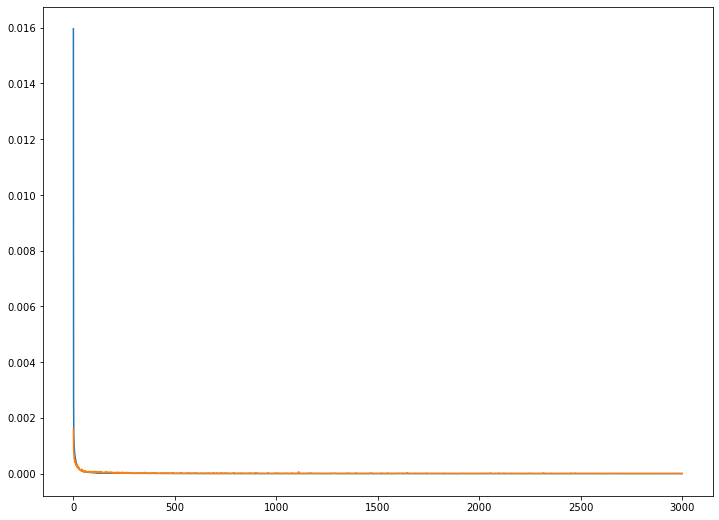

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

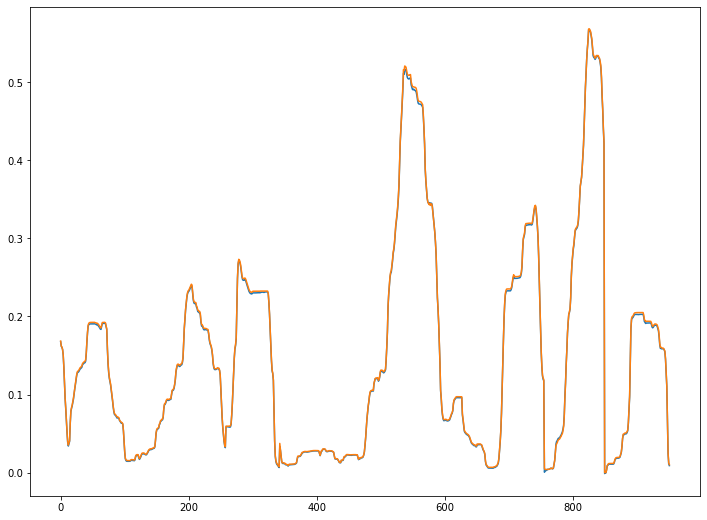

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(pred,label='prediction')
plt.plot(test_y,label='real')
plt.show()